# Poisson likelihood calculator

Given $M$ components, each with an estimated rate $\vec{\beta}$ determined by a normal distribution with uncertainty $\vec{\sigma}$, calculate the confidence itervals and perform a hypothesis tests for each parameter $b$.

Nominally each event corresponds to a set of observables $\vec{x}$ of $N$ measurements, for any given measurement, the probability for that particular measurement to come from a particular components is given by

$$ P_i(\vec{x}) \tag{1}$$

The prior probability is then formed through a combination of these components such that the total probability is 

$$ \mathbf{P} = \sum_i^M P_i(\vec{x}) \tag{2}$$

The likelihood for a full data set of $N$ measurements is the product of each event total probability

$$
\mathcal{L}(\vec{x}) = 
\prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) / \sum_i^Mb_i 
\tag{3}
$$

We can extend the likelihood by proclaiming that each components as well as the sum of components are simply a stochastic process, produces the extended likelihood:

$$
\mathcal{L}(\vec{x}) = 
\frac{\text{e}^{-\sum_i^Mb_i}}{N!} \prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) 
\tag{4}
$$

Finally, we can claim that we have _a priori_ knowledge of the parameters, whether it be through side-band analysis or external constraints, by including those constraints via some prior probability. Given no specific knowledge of the shape of that prior, we will consider the information we receive on the variables to be normally distributed and multiply the likelihood by those constraints

$$
\mathcal{L}(\vec{x}) = 
\frac{\text{e}^{-\sum_i^Mb_i}}{N!} 
\prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) 
\frac{1}{\sqrt{2\pi \sigma_j^2}}
\text{exp}\left({\frac{-(\beta_i-b_i)^2}{2\sigma_i^2}}\right)
\tag{5}
$$

A few definitions to simplify things:
$$ \lambda := \sum_i^Mb_i \tag{6}$$

Then then our objective function $\mathcal{O} = -\text{Ln}\mathcal{L}$

$$
\mathcal{O} = \lambda + \text{Ln}N! 
-\sum_j^N\text{Ln}\left( \sum_i^M b_iP_i(\vec{x}) \right) 
+ \sum_i^M \left( \frac{(\beta_i-b_i)^2}{2\sigma_i^2} 
    + \text{Ln}\sqrt{2\pi \sigma_i} \right)
\tag{7}
$$

Finally, for a counting analysis we assume that an optimal set of cuts has been applied which optimizes the sensitivity to a particular parameter, which simplifies the likelihood such that

$$ P_i(\vec{x}) := 1 \tag{8}$$

Also, because the shape of the likelihood space is independent of constant parameters, we can drop the $\text{Ln}\sqrt{2\pi \sigma_i}$ terms. We could also remove the $\text{Ln}N!$ term as well, but for numerical stability we will keep it around, but use Sterling's approximation: $\text{Ln}N! \approx N\text{Ln}N - N$. The remaining objective function we will thus use is:

$$
\mathcal{O} = \lambda - N\text{Ln}\lambda + N\text{Ln}N - N 
    + \sum_i^M \left( \frac{(\beta_i-b_i)^2}{2\sigma_i^2} \right)
\tag{9}
$$

_Note: If the different values of $\beta$ differ by orders of magnitude, it might be worth forming an affine invariant form of the likelihood, otherwise the $\text{Ln}\sqrt{2\pi \sigma_i}$ term should not matter_

[Profile Likelihood](https://www.stat.tamu.edu/~suhasini/teaching613/chapter3.pdf)

In [1]:
include("./src/WatchFish.jl")
using .WatchFish

### Model Building
Three structures are used to build, test, and fit models. These are the `Model`, `Component`, and `Result`--all of which are mutable.

We begin by initializing a default `Model` and one-by-one use `add_component!` to modify the `Model`.

The intention is to provide multiple ways to evaluate the uncertainties, the default here is to compute the profile likelihood.

In [2]:
# In the fish model we take the generic likelihood and enforce poisson statistics, thereby
# eliminating correlations between parameters.

m = Model()

add_component!(m, "Signal", 20.0; σ=Inf)
add_component!(m, "Bkg 1",  30.0; σ=10.0)
add_component!(m, "Bkg 2", 40.0; σ=35.0)
#add_component!(m, "Thing3", 10.0; σ=20.0)
#add_component!(m, "Thing4",  10.0; σ=10.0)
#add_component!(m, "Thing5", 20.0; σ=30.0)
#add_component!(m, "Thing6", 10.0; σ=20.0)

data = 130 #events
results = run_fish!(m, data)

# Results stored in a DataFrame.jl
compute_profiled_uncertainties!(results, 0.68)
pretty_results(results)

,Name,Estimate,Constraint,Fit,Interval_Low,Interval_High
,String,Float64,Float64,Float64,Float64,Float64
1,Signal,20.0,Inf,60.0,25.0,95.0
2,Bkg 1,30.0,10.0,30.0,21.0,39.0
3,Bkg 2,40.0,35.0,40.0,6.99998,73.0


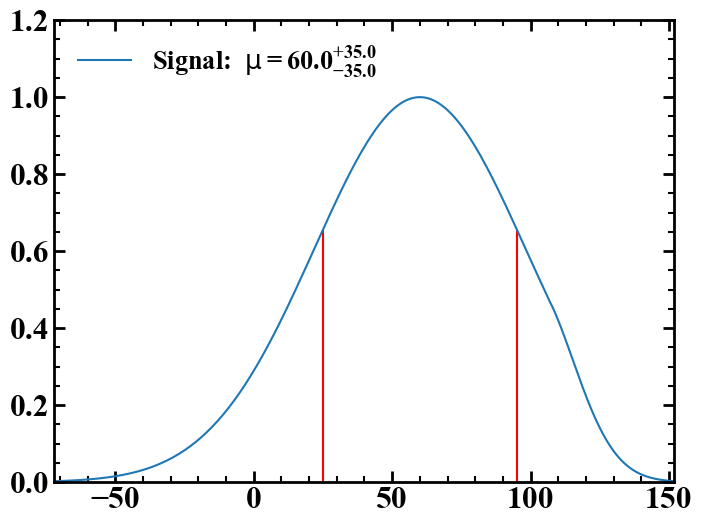

PyObject <matplotlib.legend.Legend object at 0x7f0097467dd0>

In [6]:
using PyPlot
plt.style.use("watchman")

function interval_plot(name, results)
    comp = results.model.component_dict[name]
    x, y = comp.likelihood_x, comp.likelihood_y
    low, high = comp.low, comp.high
    mid = comp.fit
    ns, ps = abs(mid - low), abs(mid - high)
    
    labeluse = "$name: " *
        " \$\\mu = $(floor(mid*100)/100)" *
        "^{+$(floor(ps*100)/100)}" *
        "_{-$(ns)}\$"
    
    plot(x, y, label=labeluse)
    
    vlines(low,0, y[x .>= low][1] , color="red")
    vlines(high,0,y[x .>= high][1], color="red")
    ylim(0, 1.2)
    xlim(minimum(x), maximum(x))
    legend(loc=2, frameon=false)
end

interval_plot("Signal", results)

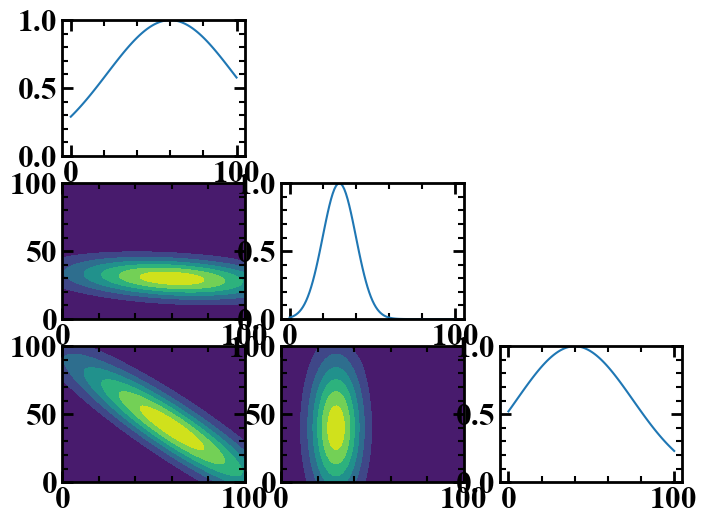

In [9]:
## Profile likelihood of each parameter
## WITHOUT a prior, we can take the normalized objective function
using PyPlot
using NLopt

## Everything stored in results
M = results.model.dims
fig, ax = subplots(nrows=M, ncols=M)

## We will be lazy for now and robust later. Lazy way, assume we know the range
x = collect(0:1:100)
y = collect(0:1:100)
X = repeat( reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
# What does a slice in space look like?
# We can optimize again, with a constraint in place (bounds)
 
for i in collect(1:M)
    for j in collect(1:M)
        if i > j
            ax[j, i].axis("off")
            continue
        end
        # profile this parameter
        nlow = copy(results.lower_bounds)
        nhigh = copy(results.upper_bounds)
        p0 = copy(results.min_parameters)
        nll = []
        if i != j
            for a in x
                for b in y
                    nlow[i], nlow[j] = a, b
                    nhigh[i], nhigh[j] = a, b
                    results.opt.lower_bounds = nlow
                    results.opt.upper_bounds = nhigh
                    #p0 = copy(results.min_parameters)
                    p0[i], p0[j] = a, b
                    minf, minx, ret = optimize!(results.opt, p0)
                    push!(nll, exp(-minf) )
                end
            end
            Z = reshape(nll, length(x), length(y))
            ax[j,i].contourf(x, y, Z)
            continue
        end
        for a in x
            nlow[i] = a
            nhigh[i] = a
            results.opt.lower_bounds = nlow
            results.opt.upper_bounds = nhigh
            p0[i] = a
            #@show opt.lower_bounds[i]
            minf, minx, ret = optimize!(results.opt, p0)
            #@show ret minf p0
            push!(nll, exp(-minf) )
        end
        ax[i,i].plot(x, nll)
        ax[i,i].set_ylim(0, 1)
    end
end
## Lets do a diagonal plot
show()

In [ ]:
# Correlation Matrix

In [ ]:
# Generate fake experiments; two set => Positive, Negative

In [ ]:
# Cowen Plot

In [ ]:
# ROC curve

In [ ]:
# Confusion Matrix

In [ ]:
# Documentation

In [ ]:
# Refactor code into sub-files, project.toml, mybinder, etc ...